In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


pandas for data handling, matplotlib and seaborn for visualization, nltk for further text processing (though much is pre-cleaned), and gensim for Word2Vec/FastText/GloVe.

In [103]:
!pip install pandas matplotlib seaborn gensim nltk scikit-learn
# NLTK downloads (only need to run once)
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4') # Open Multilingual Wordnet (for lemmatizer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# 1. Data Collection
Loading IMDB movie review dataset containing positive and negative sentiment labels. This serves as our text corpus for training word embeddings.

In [104]:
import pandas as pd

# Adjust this path to where your file is located in Google Drive
file_path = '/content/drive/MyDrive/DAM202/IMDB_cleaned.csv'
df = pd.read_csv(file_path)

print("Dataset loaded successfully!")
print(df.head())
print(df.info())
print(df.shape)

Dataset loaded successfully!
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review sentiment  
0  one of the other reviewers has mentioned that ...  positive  
1  a wonderful little production the filming tech...  positive  
2  i thought this was a wonderful way to spend ti...  positive  
3  basically there is a family where a little boy...  negative  
4  petter mattei s love in the time of money is a...  positive  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          5000 non-null   object
 1   c

## Exploratory Data Analysis

In [105]:
print("\nDescriptive Statistics:")
print(df.describe(include='all'))


Descriptive Statistics:
                                                   review  \
count                                                5000   
unique                                               4997   
top     Quite what the producers of this appalling ada...   
freq                                                    2   

                                           cleaned_review sentiment  
count                                                5000      5000  
unique                                               4997         2  
top     quite what the producers of this appalling ada...  negative  
freq                                                    2      2532  


Check for Missing Values

In [106]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
review            0
cleaned_review    0
sentiment         0
dtype: int64


### Sentiment Distribution

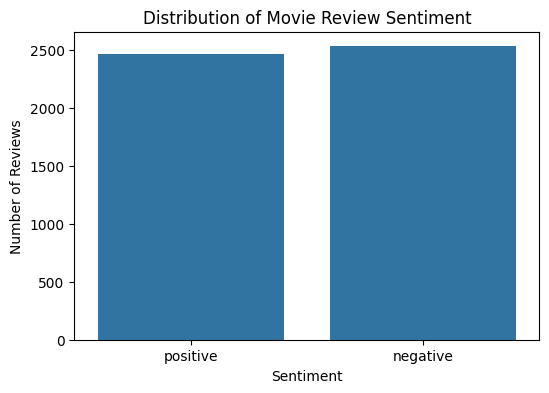

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Movie Review Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

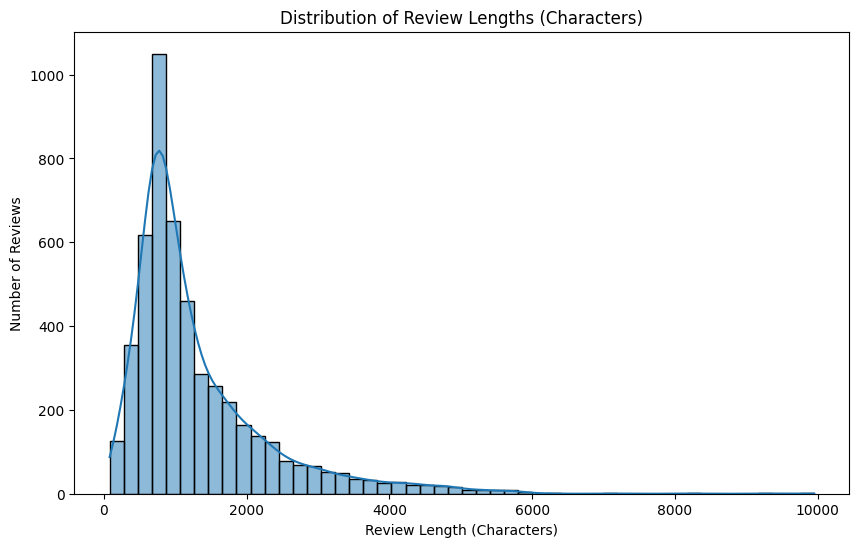


Min Review Length: 80 characters
Max Review Length: 9951 characters
Average Review Length: 1310.30 characters
Median Review Length: 965.0 characters


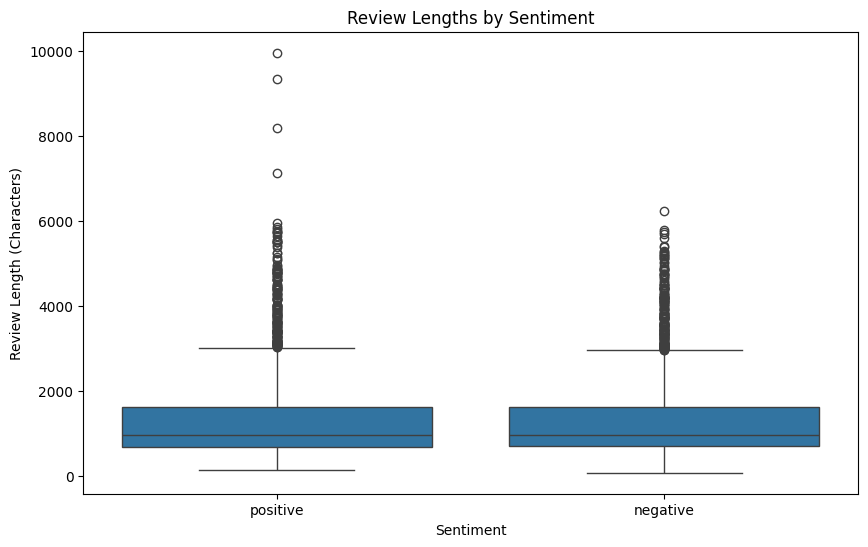

In [108]:
df['review_length'] = df['review'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (Characters)')
plt.xlabel('Review Length (Characters)')
plt.ylabel('Number of Reviews')
plt.show()

print(f"\nMin Review Length: {df['review_length'].min()} characters")
print(f"Max Review Length: {df['review_length'].max()} characters")
print(f"Average Review Length: {df['review_length'].mean():.2f} characters")
print(f"Median Review Length: {df['review_length'].median()} characters")

# You can also compare lengths by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Characters)')
plt.show()

### Word Frequency Analysis

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Most Common Words:
[('the', 57741), (',', 54263), ('.', 46252), ('a', 31056), ('and', 30846), ('of', 28577), ('to', 26242), ('is', 21383), ('/', 20669), ('>', 20632), ('<', 20628), ('br', 20624), ('in', 17322), ('I', 16187), ('it', 14962), ('that', 13627), ('this', 12114), ("'s", 12026), ('was', 9925), ('The', 8792)]


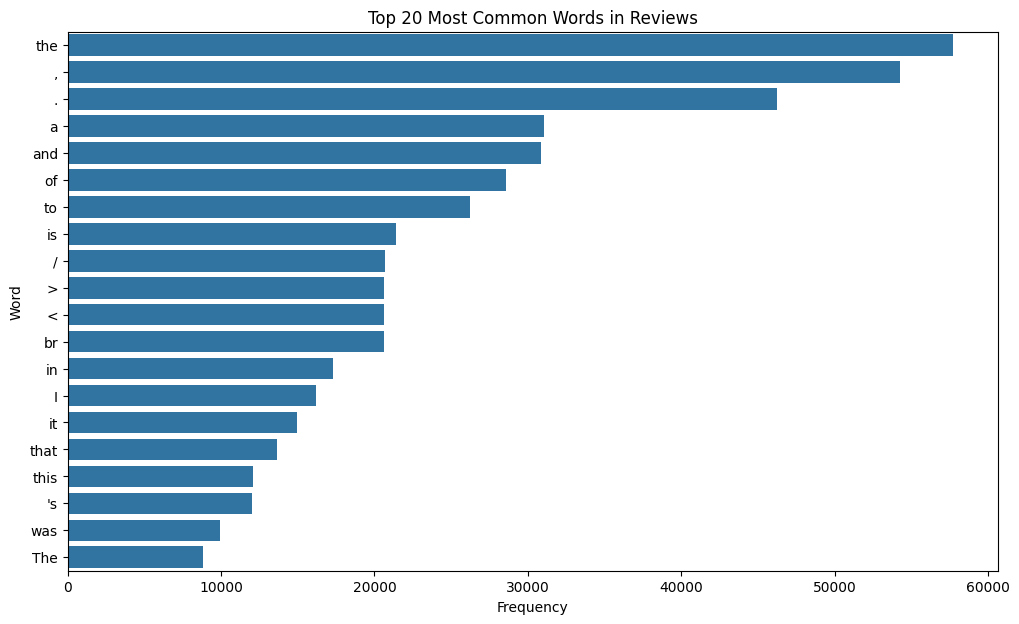

In [109]:
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

# Tokenize reviews to get individual words (this dataset is already cleaned for this)
all_words = []
for review in df['review']:
    all_words.extend(word_tokenize(review)) # NLTK's word_tokenize is good here

# Get most common words
word_freq = Counter(all_words)
common_words = word_freq.most_common(20) # Top 20 words

print("\nMost Common Words:")
print(common_words)

# Visualize most common words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Word', data=common_words_df)
plt.title('Top 20 Most Common Words in Reviews')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# 2. Preprocessing
Text preprocessing pipeline to clean and normalize the review data for optimal embedding training. Steps include lowercasing, HTML tag removal, punctuation removal, tokenization, and lemmatization.

In [110]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
# Add custom stopwords that might be noise
stop_words = set(stopwords.words('english'))
custom_stops = {'br', 'http', 'www', 'com'} # 'br' from <br> tags, http/www for links
stop_words.update(custom_stops)

def final_preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()

    # 2. HTML Tag Removal
    text = re.sub(r'<.*?>', ' ', text) # Replace with space

    # 3. URL and Link Removal
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # 4. Punctuation and Number Removal
    # Keep ONLY letters, replace everything else with a space
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # 5. Tokenization and Filtering
    # Split by spaces, then process each word
    words = []
    for word in text.split():
        # Lemmatize and check conditions
        if len(word) > 2 and word not in stop_words:
            words.append(lemmatizer.lemmatize(word))

    # 6. Join words back into a single string
    return ' '.join(words)

### Define Preprocessing Function
Creating a comprehensive text preprocessing function that handles HTML tags, URLs, punctuation removal, stopword filtering, and lemmatization.

## Apply Preprocessing

In [111]:
print("Applying preprocessing to reviews... This might take a few minutes.")
df['preprocessed_review'] = df['review'].apply(preprocess_text)
print("Preprocessing complete!")
print(df[['review', 'preprocessed_review']].head())

Applying preprocessing to reviews... This might take a few minutes.
Preprocessing complete!
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                 preprocessed_review  
0  one reviewer mentioned watching episode hooked...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically family little boy jake think zombie ...  
4  petter mattei love time money visually stunnin...  


##Re-evaluate Most Common Words


Most Common Words AFTER Preprocessing:
[('movie', 10509), ('film', 9274), ('one', 5500), ('like', 4098), ('time', 3085), ('good', 3011), ('character', 2787), ('get', 2563), ('story', 2560), ('would', 2522), ('even', 2504), ('make', 2445), ('see', 2425), ('really', 2262), ('well', 2197), ('scene', 2152), ('much', 1982), ('bad', 1888), ('first', 1803), ('people', 1798)]


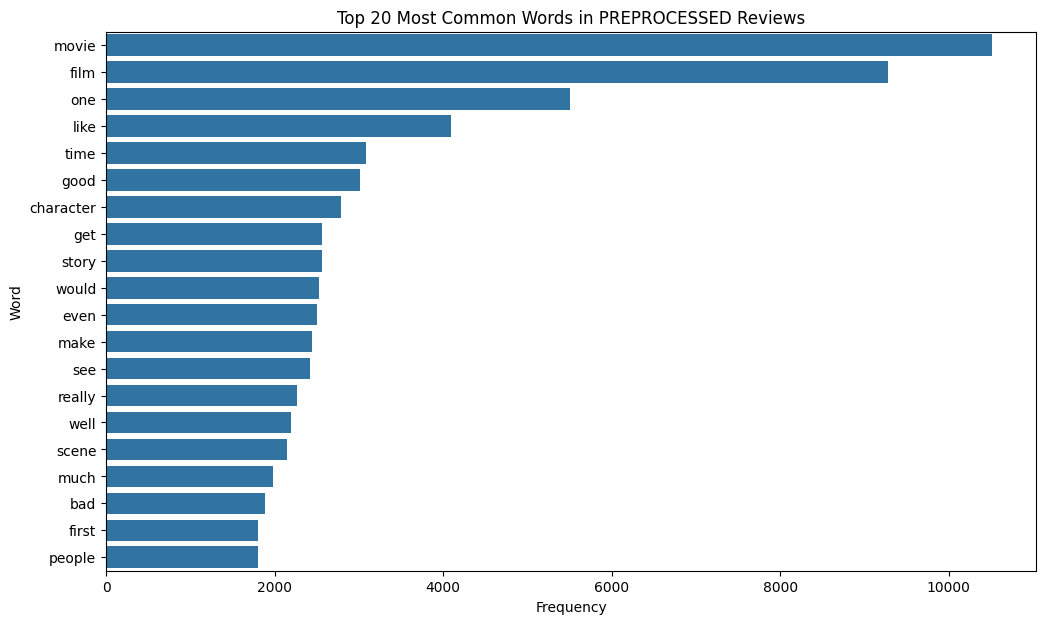

In [129]:
# Tokenize preprocessed reviews to get individual words
all_preprocessed_words = []
for review in df['preprocessed_review']:
    all_preprocessed_words.extend(word_tokenize(review))

# Get most common words from preprocessed text
word_freq_preprocessed = Counter(all_preprocessed_words)
common_words_preprocessed = word_freq_preprocessed.most_common(20) # Top 20 words

print("\nMost Common Words AFTER Preprocessing:")
print(common_words_preprocessed)

# Visualize most common words
common_words_df_preprocessed = pd.DataFrame(common_words_preprocessed, columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Word', data=common_words_df_preprocessed)
plt.title('Top 20 Most Common Words in PREPROCESSED Reviews')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

##word cloud image

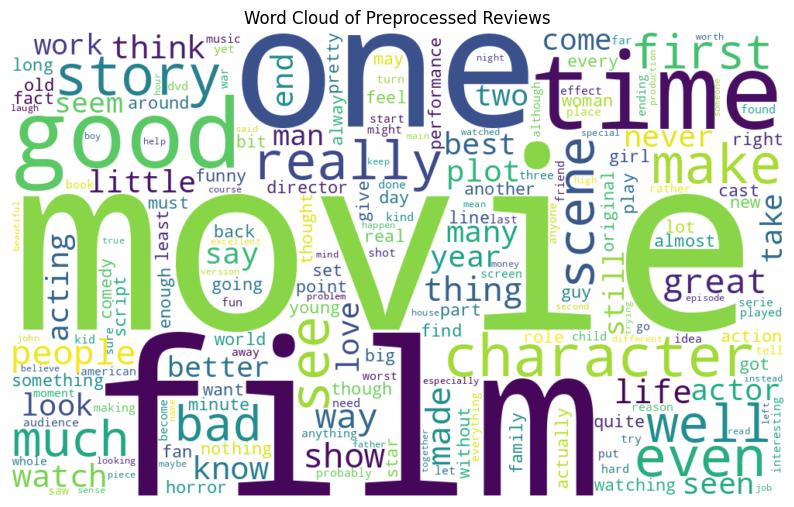

In [113]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all preprocessed words into a single string
# Assuming 'all_preprocessed_words' is already generated from your previous code
text_for_wordcloud = " ".join(all_preprocessed_words)

# Generate a word cloud image
wordcloud = WordCloud(width=1000, height=600,
                      background_color='white',
                      collocations=False, # Set to True if you want to include bi-grams
                      min_font_size=10).generate(text_for_wordcloud)

# Display the generated image:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Preprocessed Reviews')
plt.show()

### Save the Cleaned Data

In [114]:
# Define the output filename
cleaned_file_path = '/content/drive/MyDrive/DAM202/IMDB_custom_cleaned.csv'

# Save the DataFrame to a new CSV
if 'preprocessed_review' in df.columns:
    df.to_csv(cleaned_file_path, index=False)
    print(f"Cleaned data saved successfully to '{cleaned_file_path}'")
else:
    print("Skipping save because preprocessing did not complete.")



Cleaned data saved successfully to '/content/drive/MyDrive/DAM202/IMDB_custom_cleaned.csv'


In [127]:
from nltk.tokenize import word_tokenize

# Number of documents
num_docs = df.shape[0]

# Total tokens before cleaning
num_tokens = df['review'] \
    .apply(lambda text: len(word_tokenize(text))) \
    .sum()

print(f"Number of documents: {num_docs}")
print(f"Total tokens before cleaning: {num_tokens}")

Number of documents: 5000
Total tokens before cleaning: 1398280


In [128]:
from nltk.tokenize import word_tokenize

# Number of documents (unchanged)
num_docs = df.shape[0]

# Total tokens after cleaning
num_tokens_clean = df['preprocessed_review'] \
    .apply(lambda text: len(word_tokenize(text))) \
    .sum()

# Vocabulary size after cleaning
all_tokens = [tok
              for text in df['preprocessed_review']
              for tok in word_tokenize(text)]
vocab_size = len(set(all_tokens))

print(f"Number of documents: {num_docs}")
print(f"Total tokens after preprocessing: {num_tokens_clean}")
print(f"Vocabulary size after preprocessing: {vocab_size}")

Number of documents: 5000
Total tokens after preprocessing: 583481
Vocabulary size after preprocessing: 34229


# 3. Embedding Training
Training FastText model using Skip-gram architecture to learn dense vector representations of words. FastText captures both semantic and syntactic relationships while handling out-of-vocabulary words through character n-grams.

### Model Choice Justification

For this project, we are choosing the **FastText** model for training our word embeddings. The primary reasons for this choice are:

1.  **Handling Out-of-Vocabulary (OOV) Words:** Unlike Word2Vec, FastText represents words as a bag of character n-grams. This allows it to generate embeddings for words that were not in the training vocabulary, which is a significant advantage when dealing with real-world text containing typos, slang, or rare words.
2.  **Performance on Smaller Datasets:** FastText often achieves good performance even on medium-sized datasets like the IMDb corpus because the subword information helps create better representations for all words, including infrequent ones.

In [115]:
from gensim.models import FastText

print("Preparing data for FastText...")
# The model expects a list of lists of tokens (sentences)
# We split the strings in 'preprocessed_review' into lists of words
sentences = [review.split() for review in df['preprocessed_review']]

print("Training the FastText model... This may take a few minutes.")

# Train the FastText model using parameters from the project plan
# sg=1 indicates that we are using the Skip-gram algorithm
model = FastText(
    sentences=sentences,
    vector_size=100,      # Embedding dimension
    window=5,             # Context window size
    min_count=1,          # Ignore words with frequency lower than this
    min_n=3,              # Min length of character n-grams
    max_n=6,              # Max length of character n-grams
    workers=4,            # Number of worker threads
    sg=1,
    epochs=20             # Use Skip-gram
)

print("FastText model trained successfully!")

Preparing data for FastText...
Training the FastText model... This may take a few minutes.
FastText model trained successfully!


### Train FastText Model
Training the FastText model with optimized hyperparameters: 100-dimensional vectors, 5-word context window, character n-grams (3-6), and Skip-gram architecture for 20 epochs.

In [116]:
# Define the path in Google Drive to save the model
model_save_path = '/content/drive/MyDrive/DAM202/fasttext_model.model'

# Save the model
model.save(model_save_path)

print(f"Model saved successfully to: {model_save_path}")

Model saved successfully to: /content/drive/MyDrive/DAM202/fasttext_model.model


## Save Model

# 4. Evaluation
Comprehensive evaluation of the trained word embeddings through multiple approaches: word similarity tests, analogy tasks, visualization, and downstream sentiment analysis performance.

##Intrinsic Evaluation

In [117]:
from gensim.models import FastText

# Load the model from your Google Drive
model_load_path = '/content/drive/MyDrive/DAM202/fasttext_model.model'
model = FastText.load(model_load_path)

print("Model loaded successfully!")

Model loaded successfully!


### Test Word Similarity
Testing the model's ability to identify semantically similar words using cosine similarity. This evaluates if words with similar meanings cluster together in the embedding space.

In [118]:
# --- Word Similarity Tests ---
print("--- Testing Word Similarity ---")

# Test 1: Find words similar to "movie"
try:
    similar_to_movie = model.wv.most_similar('movie', topn=10)
    print("\nWords most similar to 'movie':")
    for word, score in similar_to_movie:
        print(f"- {word} (Score: {score:.4f})")
except KeyError:
    print("\n'movie' not in vocabulary.")

# Test 2: Find words similar to "actor"
try:
    similar_to_actor = model.wv.most_similar('actor', topn=10)
    print("\nWords most similar to 'actor':")
    for word, score in similar_to_actor:
        print(f"- {word} (Score: {score:.4f})")
except KeyError:
    print("\n'actor' not in vocabulary.")

# Test 3: Find words similar to "thriller"
try:
    similar_to_thriller = model.wv.most_similar('thriller', topn=10)
    print("\nWords most similar to 'thriller':")
    for word, score in similar_to_thriller:
        print(f"- {word} (Score: {score:.4f})")
except KeyError:
    print("\n'thriller' not in vocabulary.")

--- Testing Word Similarity ---

Words most similar to 'movie':
- fdfs (Score: 0.8419)
- film (Score: 0.8374)
- thismovie (Score: 0.8341)
- moviesthat (Score: 0.8176)
- moviefan (Score: 0.8162)
- avpr (Score: 0.8081)
- ttfn (Score: 0.8076)
- tlkg (Score: 0.8065)
- tb (Score: 0.8038)
- ftm (Score: 0.7996)

Words most similar to 'actor':
- tractor (Score: 0.7409)
- ctor (Score: 0.7400)
- factor (Score: 0.7332)
- reactor (Score: 0.7263)
- detractor (Score: 0.6666)
- compactor (Score: 0.6405)
- contractor (Score: 0.5853)
- hector (Score: 0.5823)
- vector (Score: 0.5703)
- actingugh (Score: 0.5694)

Words most similar to 'thriller':
- thrill (Score: 0.8647)
- thrilled (Score: 0.8481)
- driller (Score: 0.7978)
- thrilling (Score: 0.7730)
- thrifty (Score: 0.7434)
- thrive (Score: 0.7362)
- painkiller (Score: 0.7059)
- filler (Score: 0.6925)
- suspenser (Score: 0.6860)
- diller (Score: 0.6809)


### Test Word Analogies
Evaluating the model's understanding of semantic relationships through vector arithmetic. Tests if the model can solve analogies like "good:bad :: excellent:?" by manipulating word vectors.

In [119]:
# --- Analogy Task ---
print("\n--- Testing Word Analogies ---")

# Analogy: good - bad + excellent = ?
try:
    analogy_new = model.wv.most_similar(positive=['good', 'excellent'], negative=['bad'], topn=5)
    print("\nAnalogy: good - bad + excellent = ?")
    for word, score in analogy_new:
        print(f"- {word} (Score: {score:.4f})")
except KeyError as e:
    print(f"\nCould not perform analogy 'good - bad + excellent' due to missing word: {e}")

# Analogy 2: actor - man + woman = actress
try:
    analogy2 = model.wv.most_similar(positive=['actor', 'woman'], negative=['man'], topn=5)
    print("\nAnalogy: actor - man + woman = ?")
    for word, score in analogy2:
        print(f"- {word} (Score: {score:.4f})")
except KeyError as e:
    print(f"\nCould not perform analogy 'actor - man + woman' due to missing word: {e}")




--- Testing Word Analogies ---

Analogy: good - bad + excellent = ?
- excellency (Score: 0.7015)
- excels (Score: 0.6796)
- excel (Score: 0.6735)
- excelled (Score: 0.6654)
- excellently (Score: 0.6516)

Analogy: actor - man + woman = ?
- tractor (Score: 0.5772)
- reactor (Score: 0.5665)
- factor (Score: 0.5613)
- ctor (Score: 0.5473)
- actress (Score: 0.5329)


## t-SNE Visualization
Using t-SNE to reduce 100-dimensional word vectors to 2D for visualization. This reveals semantic clustering patterns and relationships between words in the embedding space.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


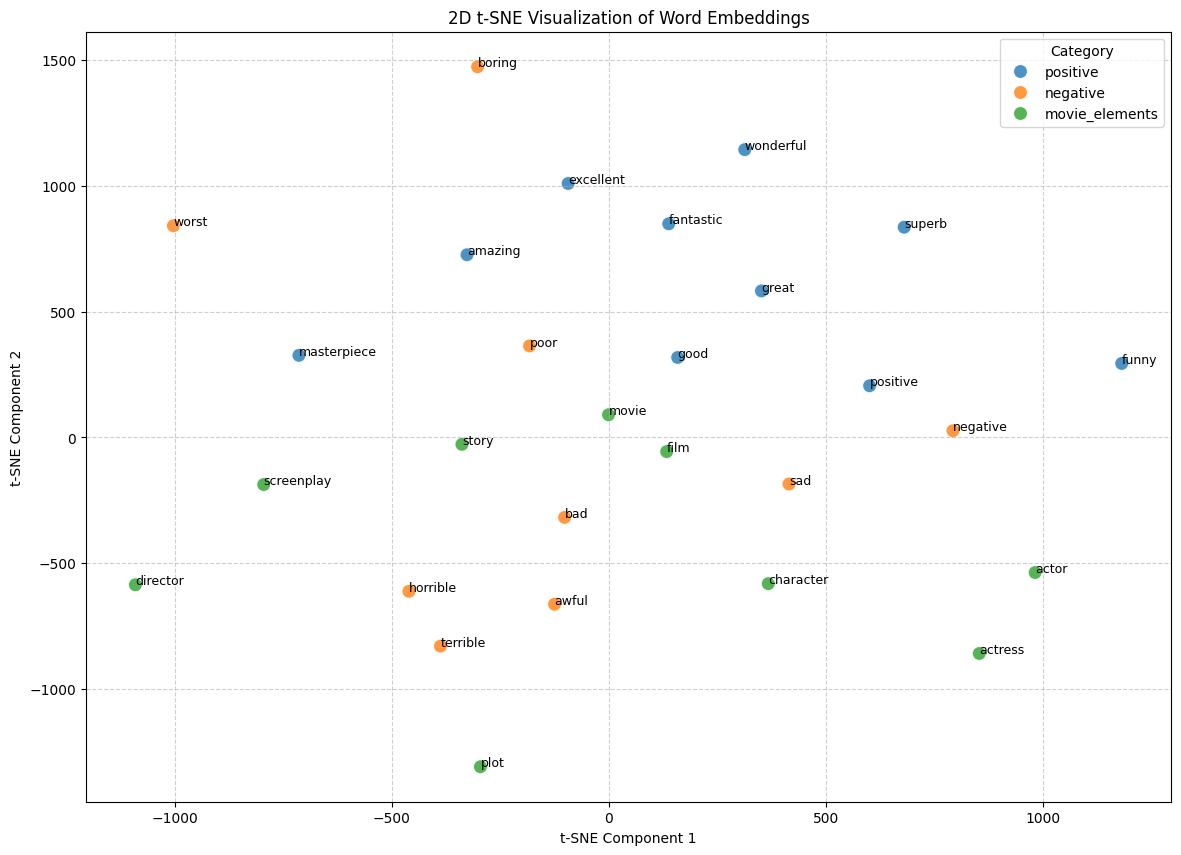

In [120]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Select a subset of words for visualization

words_to_visualize = [
    'good', 'great', 'excellent', 'amazing', 'superb', 'positive', 'wonderful',
    'bad', 'horrible', 'terrible', 'awful', 'negative', 'poor', 'worst',
    'movie', 'film', 'director', 'actor', 'actress', 'screenplay', 'plot', 'character', 'story',
    'funny', 'sad', 'boring', 'fantastic', 'masterpiece'
]

# Filter out words not in the model's vocabulary
present_words = [word for word in words_to_visualize if word in model.wv.key_to_index]
missing_words = [word for word in words_to_visualize if word not in model.wv.key_to_index]

if missing_words:
    print(f"\nWarning: The following words were requested for visualization but are not in the model's vocabulary and will be skipped: {missing_words}")

if not present_words:
    print("\nError: No words from the selected list are present in the model's vocabulary for visualization.")
else:
    # 2. Get the word vectors for the present words
    word_vectors = np.array([model.wv[word] for word in present_words])

    # 3. Apply t-SNE to reduce dimensions to 2D
    # Perplexity is a crucial parameter, often chosen between 5 and 50.
    # n_iter_early_exag and learning_rate can also be tuned.
    tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=2000, learning_rate=200)
    reduced_vectors = tsne.fit_transform(word_vectors)

    # 4. Create a DataFrame for plotting
    df_tsne = pd.DataFrame(reduced_vectors, columns=['Component 1', 'Component 2'])
    df_tsne['Word'] = present_words

    # Optional: Assign categories for coloring
    sentiment_categories = {
        'positive': ['good', 'great', 'excellent', 'amazing', 'superb', 'positive', 'wonderful', 'funny', 'fantastic', 'masterpiece'],
        'negative': ['bad', 'horrible', 'terrible', 'awful', 'negative', 'poor', 'worst', 'sad', 'boring'],
        'movie_elements': ['movie', 'film', 'director', 'actor', 'actress', 'screenplay', 'plot', 'character', 'story']
    }

    def get_category(word):
        for category, words_in_category in sentiment_categories.items():
            if word in words_in_category:
                return category
        return 'other' # Fallback for any word not explicitly categorized

    df_tsne['Category'] = df_tsne['Word'].apply(get_category)

    # 5. Plotting
    plt.figure(figsize=(14, 10))
    sns.scatterplot(x='Component 1', y='Component 2', hue='Category', data=df_tsne, s=100, alpha=0.8)

    # Add labels for each word
    for i, row in df_tsne.iterrows():
        plt.annotate(row['Word'], (row['Component 1'] + 0.1, row['Component 2'] + 0.1), fontsize=9)

    plt.title('2D t-SNE Visualization of Word Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Category')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## Sentiment Analysis
Downstream task evaluation using word embeddings as features for sentiment classification. This tests the practical utility of our embeddings.

### Create Document Vectors
Converting variable-length reviews into fixed-size vectors by averaging word embeddings. This creates document-level representations for classification.

In [121]:
import numpy as np

def create_document_vector(text, model):
    # Tokenize the text
    words = text.split()

    # Get the vector for each word in the review, if it exists in the model
    word_vectors = [model.wv[word] for word in words if word in model.wv]

    if not word_vectors:
        # If no words in the review are in the vocabulary, return a vector of zeros
        return np.zeros(model.vector_size)

    # Average the word vectors to get the document vector
    document_vector = np.mean(word_vectors, axis=0)
    return document_vector

# Apply this function to every review in your DataFrame
print("Creating document vectors for each review...")
df['doc_vector'] = df['preprocessed_review'].apply(lambda x: create_document_vector(x, model))
print("Document vectors created successfully!")

# Display the first few document vectors
print(df[['preprocessed_review', 'doc_vector']].head())

Creating document vectors for each review...
Document vectors created successfully!
                                 preprocessed_review  \
0  one reviewer mentioned watching episode hooked...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically family little boy jake think zombie ...   
4  petter mattei love time money visually stunnin...   

                                          doc_vector  
0  [-0.07195455, 0.22096285, -0.025710128, 0.0798...  
1  [-0.14936328, 0.16472255, -0.02496913, 0.03535...  
2  [-0.16449252, 0.12900601, -0.047194753, 0.0735...  
3  [-0.084090374, 0.12189771, -0.12624343, -0.021...  
4  [-0.15970369, 0.2009612, -0.11644627, 0.110599...  


### Implement Document Vector Creation
Creating document-level representations by averaging word embeddings within each review. This transforms variable-length text into fixed-size vectors suitable for machine learning.

### Prepare Data

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# The features (X) are the document vectors
X = np.array(df['doc_vector'].tolist())

# The labels (y) are the sentiments
# We need to convert 'positive' and 'negative' to 1 and 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Data split into training and testing sets.
X_train shape: (4000, 100)
X_test shape: (1000, 100)


### Train Classifier
### Train Sentiment Classifier
Training a Logistic Regression classifier using document vectors as features to predict sentiment. This evaluates the quality of embeddings on a downstream classification task.

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize and train the classifier
print("Training the Logistic Regression classifier...")
classifier = LogisticRegression(max_iter=1000) # max_iter increased for convergence
classifier.fit(X_train, y_train)
print("Classifier trained successfully.")

# Make predictions on the test set
print("Making predictions on the test set...")
y_pred = classifier.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Evaluation Complete ---")
print(f"Sentiment Analysis Accuracy: {accuracy * 100:.2f}%")

Training the Logistic Regression classifier...
Classifier trained successfully.
Making predictions on the test set...

--- Evaluation Complete ---
Sentiment Analysis Accuracy: 83.40%


### Visualize Results
Creating a confusion matrix to visualize classification performance and identify prediction patterns between positive and negative sentiment classes.

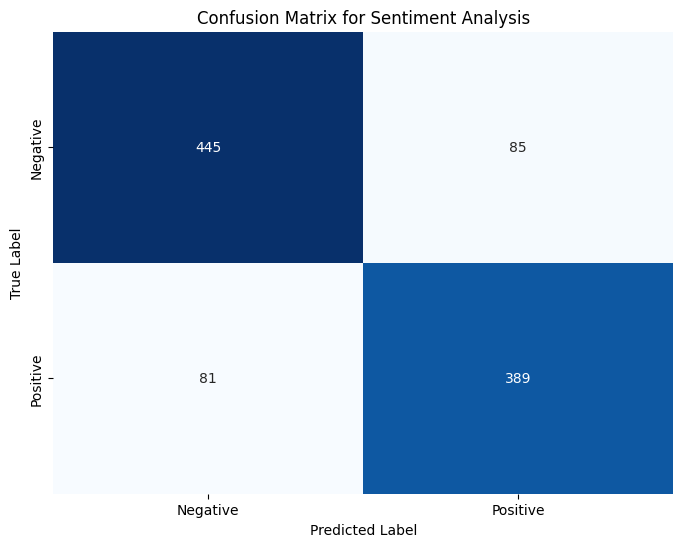

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()